In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install aif360
!pip install BlackBoxAuditing
!pip install fairlearn==0.4.6

# Load Data

In [3]:
from aif360.datasets import BinaryLabelDataset

/home/sophie/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sophie/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sophie/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sophie/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [4]:
adult_numerical = pd.read_csv('fairness/data/preprocessed/adult_numerical.csv')
filtered_idx = adult_numerical['race'] != 'Other'
adult_numerical = adult_numerical[filtered_idx]
adult_numerical['race-sex'] = adult_numerical['race-sex'].astype('category')
map_race_sex = dict( enumerate(adult_numerical['race-sex'].cat.categories))
adult_numerical['race-sex'] = adult_numerical['race-sex'].cat.codes

adult_numerical['race'] = adult_numerical['race'].astype('category')
map_race = dict( enumerate(adult_numerical['race'].cat.categories))
adult_numerical['race'] = adult_numerical['race'].cat.codes


adult_numerical['sex'] = adult_numerical['sex'].astype('category')
map_sex = dict( enumerate(adult_numerical['sex'].cat.categories))
adult_numerical['sex'] = adult_numerical['sex'].cat.codes

adult_numerical['income-per-year'] = adult_numerical['income-per-year'].astype('category')
map_income = dict( enumerate(adult_numerical['income-per-year'].cat.categories))
adult_numerical['income-per-year'] = adult_numerical['income-per-year'].cat.codes


In [5]:
adult_binary = BinaryLabelDataset(df=adult_numerical,
                                  label_names=['income-per-year'], 
                                  protected_attribute_names=['race-sex'], 
                                  instance_weights_name=None, 
                                  scores_names=[], 
                                  unprivileged_protected_attributes=[], 
                                  privileged_protected_attributes=[], 
                                  metadata=None)

In [6]:
ad_train, ad_test = adult_binary.split(2)

In [7]:
from sklearn.metrics import log_loss
def gen_gap_per_group(pred_prob_train, Y_train, attr_train, pred_prob_test, Y_test, attr_test):
    unique_attr = np.unique(attr_train)
    for a in unique_attr:
        ind_train = (attr_train == a)
        Y_train_a = Y_train[ind_train]
        pred_prob_train_a = pred_prob_train[ind_train]
        
        ind_test = (attr_test == a)
        Y_test_a = Y_test[ind_test]
        pred_prob_test_a = pred_prob_test[ind_test]
        
        gap = abs(log_loss(Y_train_a, pred_prob_train_a) - log_loss(Y_test_a, pred_prob_test_a))
        print('generalization gap for group {}: {}'.format(a, gap))

# Unconstrained Model

In [8]:
from sklearn.linear_model import LogisticRegression
from copy import deepcopy
from aif360.metrics import ClassificationMetric

In [9]:
ad_df_train, ad_attrs_train = ad_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
ad_df_test, ad_attrs_test = ad_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)

In [10]:
ad_df_train.head()

,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,race-sex,workclass_Federal-gov,workclass_Local-gov,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income-per-year
0,39.0,13.0,3.0,1.0,2174.0,0.0,40.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,50.0,13.0,3.0,1.0,0.0,0.0,13.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,38.0,9.0,3.0,1.0,0.0,0.0,40.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,53.0,7.0,2.0,1.0,0.0,0.0,40.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,28.0,13.0,2.0,0.0,0.0,0.0,40.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
Y_train = np.array(ad_df_train[['income-per-year']]).reshape(((len(ad_df_train),))).astype(int)
Xs_train = np.array(ad_df_train.drop(columns='income-per-year'))
Y_test = np.array(ad_df_test[['income-per-year']]).reshape(((len(ad_df_test),))).astype(int)
Xs_test = np.array(ad_df_test.drop(columns='income-per-year'))

In [12]:
clf = LogisticRegression(max_iter = 300, solver='liblinear').fit(Xs_train, Y_train)

In [13]:
predicted_labels_train = clf.predict(Xs_train).reshape((len(Y_train), 1))
predicted_labels = clf.predict(Xs_test).reshape((len(Y_test), 1))

In [14]:
ad_pred = deepcopy(ad_test)
ad_pred_train = deepcopy(ad_train)
ad_pred.labels = predicted_labels
ad_pred_train.labels = predicted_labels_train

In [15]:
u = [{'race-sex': 0, 'race-sex': 1, 'race-sex': 2, 'race-sex': 3, 'race-sex': 4, 'race-sex': 5, 'race-sex': 6}]
p = [{'race-sex': 7}]
metrics = ClassificationMetric(ad_test,ad_pred,unprivileged_groups=u, privileged_groups=p)
test_acc = metrics.accuracy()
DI = metrics.disparate_impact()
EO = metrics.average_abs_odds_difference()
print('Original Test Accuracy:', test_acc)
print('Original Demographic Parity ratio:', DI)
print('Original Average Absolute Odds diff:', EO)

Original Test Accuracy: 0.8460407617774808
Original Demographic Parity ratio: 0.2996890474115724
Original Average Absolute Odds diff: 0.0921651727995266


### Membership Inference Attack

In [16]:
from mia.membership_inference_attacks import black_box_benchmarks

In [17]:
# Membership inference attack

# train shadow model
shadow_train, shadow_test = ad_test.split(2)
shadow_train_df, _ = shadow_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
shadow_test_df, _ = shadow_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
shadow_Y_train = np.array(shadow_train_df[['income-per-year']]).reshape(((len(shadow_train_df),))).astype(int)
shadow_Xs_train = np.array(shadow_train_df.drop(columns='income-per-year'))
shadow_Y_test = np.array(shadow_test_df[['income-per-year']]).reshape(((len(shadow_test_df),))).astype(int)
shadow_Xs_test = np.array(shadow_test_df.drop(columns='income-per-year'))

true_pred_on_shadow_train = clf.predict(shadow_Xs_train)
true_pred_on_shadow_test = clf.predict(shadow_Xs_test)

shadow_model = LogisticRegression(max_iter = 300, solver='liblinear').fit(shadow_Xs_train, true_pred_on_shadow_train)


In [18]:
# get outputs
shadow_out_train = shadow_model.predict_proba(shadow_Xs_train)
shadow_out_test = shadow_model.predict_proba(shadow_Xs_test)
true_model_train = clf.predict_proba(Xs_train)
true_model_test = clf.predict_proba(Xs_test)

In [19]:
shadow_train_performance = (shadow_out_train, true_pred_on_shadow_train)
shadow_test_performance = (shadow_out_test, true_pred_on_shadow_test)
target_train_performance = (true_model_train, Y_train)
target_test_performance = (true_model_test, Y_test)

In [20]:
shadow_train_df['race-sex'] = shadow_train_df['race'].astype(str) + '-' + shadow_train_df['sex'].astype(str)
shadow_train_df['race-sex'] = shadow_train_df['race-sex'].astype('category').cat.codes
shadow_test_df['race-sex'] = shadow_test_df['race'].astype(str) + '-' + shadow_test_df['sex'].astype(str)
shadow_test_df['race-sex'] = shadow_test_df['race-sex'].astype('category').cat.codes
ad_df_train['race-sex'] = ad_df_train['race'].astype(str) + '-' + ad_df_train['sex'].astype(str)
ad_df_train['race-sex'] = ad_df_train['race-sex'].astype('category').cat.codes
ad_df_test['race-sex'] = ad_df_test['race'].astype(str) + '-' + ad_df_test['sex'].astype(str)
ad_df_test['race-sex'] = ad_df_test['race-sex'].astype('category').cat.codes

In [21]:
shadow_attr_train = shadow_train_df['race-sex'].astype(int)
shadow_attr_test = shadow_test_df['race-sex'].astype(int)
train_attr = ad_df_train['race-sex'].astype(int)
test_attr = ad_df_test['race-sex'].astype(int)

In [22]:
# run MIA
MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [23]:
MIA._mem_inf_benchmarks(shadow_attr_train, shadow_attr_test, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.499, with train acc 0.845 and test acc 0.846
For membership inference attack via confidence, group attr 0, the attack acc is 0.516
For membership inference attack via confidence, group attr 1, the attack acc is 0.500
For membership inference attack via confidence, group attr 2, the attack acc is 0.500
For membership inference attack via confidence, group attr 3, the attack acc is 0.519
For membership inference attack via confidence, group attr 4, the attack acc is 0.501
For membership inference attack via confidence, group attr 5, the attack acc is 0.495
For membership inference attack via confidence, group attr 6, the attack acc is 0.498
For membership inference attack via confidence, group attr 7, the attack acc is 0.497
For membership inference attack via confidence, the attack acc is 0.498
For membership inference attack via entropy, group attr 0, the attack acc is 0.516
For membership inference attack via entropy

In [24]:
# white box MIA for reference
MIA_wb = black_box_benchmarks(target_train_performance,target_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [25]:
MIA_wb._mem_inf_benchmarks(train_attr, test_attr, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.499, with train acc 0.845 and test acc 0.846
For membership inference attack via confidence, group attr 0, the attack acc is 0.551
For membership inference attack via confidence, group attr 1, the attack acc is 0.581
For membership inference attack via confidence, group attr 2, the attack acc is 0.571
For membership inference attack via confidence, group attr 3, the attack acc is 0.534
For membership inference attack via confidence, group attr 4, the attack acc is 0.524
For membership inference attack via confidence, group attr 5, the attack acc is 0.518
For membership inference attack via confidence, group attr 6, the attack acc is 0.509
For membership inference attack via confidence, group attr 7, the attack acc is 0.504
For membership inference attack via confidence, the attack acc is 0.509
For membership inference attack via entropy, group attr 0, the attack acc is 0.560
For membership inference attack via entropy

In [26]:
# measure memorization
gen_gap_per_group(true_model_train, Y_train, train_attr, true_model_test, Y_test, test_attr)

generalization gap for group 0: 0.026538831210573266
generalization gap for group 1: 0.09866577643288499
generalization gap for group 2: 0.17538865348881075
generalization gap for group 3: 0.002220065245218228
generalization gap for group 4: 0.01795451880166976
generalization gap for group 5: 0.00017744523551793678
generalization gap for group 6: 0.000796687713221389
generalization gap for group 7: 0.011224237990104968


### Privacy Risk Score Analysis

In [27]:
from mia.privacy_risk_score_utils import calculate_risk_score

In [28]:
print(map_race_sex)
print(map_race)
print(map_sex)
print(map_income)

{0: 'Amer-Indian-Eskimo-Female', 1: 'Amer-Indian-Eskimo-Male', 2: 'Asian-Pac-Islander-Female', 3: 'Asian-Pac-Islander-Male', 4: 'Black-Female', 5: 'Black-Male', 6: 'White-Female', 7: 'White-Male'}
{0: 'Amer-Indian-Eskimo', 1: 'Asian-Pac-Islander', 2: 'Black', 3: 'White'}
{0: 'Female', 1: 'Male'}
{0: '<=50K', 1: '>50K'}


In [29]:
def risk_hist(attr_map, attr_name, ad_df_train, risk_scores):
    for key in attr_map:
        idx = ad_df_train[attr_name] == key
        plt.hist(risk_scores[idx], label=attr_map[key], density=True, alpha=0.5)
    plt.legend()
    plt.xlabel('privacy risk score')
    plt.ylabel('frequency')
    plt.savefig('{}.png'.format(attr_name))

In [30]:
tr_values = MIA._entr_comp(shadow_out_train)
te_values = MIA._entr_comp(shadow_out_test)
data_values = MIA._entr_comp(true_model_train)

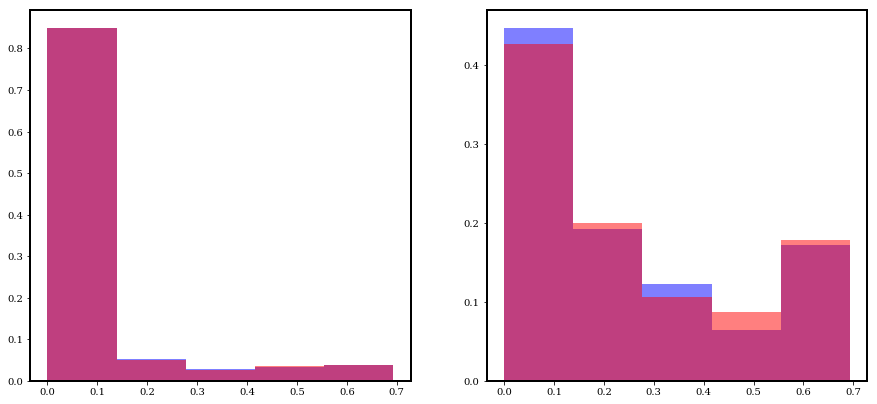

In [31]:
# get risk scores
risk_scores = calculate_risk_score(tr_values, te_values, 
                                   true_pred_on_shadow_train, 
                                   true_pred_on_shadow_test, 
                                   data_values, Y_train, num_bins=5, log_bins=False)

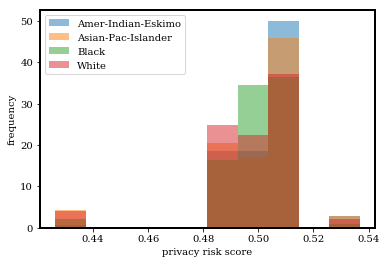

In [32]:
risk_hist(map_race, 'race', ad_df_train, risk_scores)

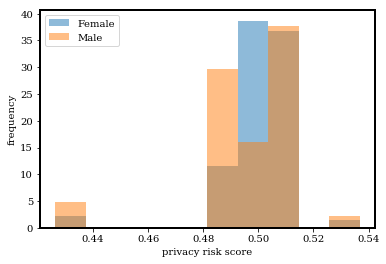

In [33]:
risk_hist(map_sex, 'sex', ad_df_train, risk_scores)

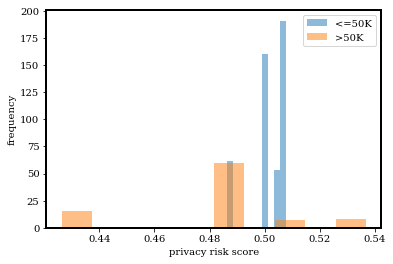

In [34]:
risk_hist(map_income, 'income-per-year', ad_df_train, risk_scores)

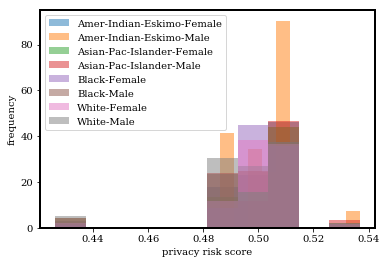

In [35]:
risk_hist(map_race_sex, 'race-sex', ad_df_train, risk_scores)

# Demographic Parity (Independence)

## Feldman et al. Repair (Preprocessing)

In [36]:
import aif360.algorithms.preprocessing as AIF

In [37]:
# tuning repair level to minimize test accuracy tradeoff
x = np.arange(0, 1.1, 0.1)
test_acc = []
dp = []
for rep in x:
    repairer = AIF.DisparateImpactRemover(repair_level=rep, sensitive_attribute='race-sex')
    repaired_train = repairer.fit_transform(ad_train)
    repaired_test = repairer.fit_transform(ad_test)
    repaired_df_train, repaired_attrs_train = repaired_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
    repaired_df_test, repaired_attrs_test = repaired_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
    Y_rep_train = np.array(repaired_df_train[['income-per-year']]).reshape(((len(repaired_df_train),)))
    Xs_rep_train = np.array(repaired_df_train.drop(columns='income-per-year'))

    Y_rep_test = np.array(repaired_df_test[['income-per-year']]).reshape(((len(repaired_df_test),)))
    Xs_rep_test = np.array(repaired_df_test.drop(columns='income-per-year'))
    clf_rep = LogisticRegression(max_iter = 300, solver='liblinear').fit(Xs_rep_train, Y_rep_train)
    predicted_labels_rep = clf_rep.predict(Xs_rep_test).reshape((len(Y_rep_test), 1))
    ad_pred_rep = deepcopy(ad_test)
    ad_pred_rep.labels = predicted_labels_rep
    metrics_rep = ClassificationMetric(ad_test,ad_pred_rep,unprivileged_groups=u, privileged_groups=p)
    test_acc_rep = metrics_rep.accuracy()
    DI_rep = metrics_rep.disparate_impact()
    EO_rep = metrics_rep.average_abs_odds_difference()
    print('Repair Test Accuracy:', test_acc_rep)
    print('Repair Demographic Parity ratio:', DI_rep)
    print('Repair Average Absolute Odds diff:', EO_rep)
    test_acc.append(test_acc_rep)
    dp.append(DI_rep)

Repair Test Accuracy: 0.8460407617774808
Repair Demographic Parity ratio: 0.2996890474115724
Repair Average Absolute Odds diff: 0.0921651727995266
Repair Test Accuracy: 0.8408954226528567
Repair Demographic Parity ratio: 0.3394946668003241
Repair Average Absolute Odds diff: 0.04862292852946082
Repair Test Accuracy: 0.8342799866354828
Repair Demographic Parity ratio: 0.3468472819773562
Repair Average Absolute Odds diff: 0.03150792385649004
Repair Test Accuracy: 0.8203140661543602
Repair Demographic Parity ratio: 0.3687730033392927
Repair Average Absolute Odds diff: 0.017384281993712208
Repair Test Accuracy: 0.843701971266288
Repair Demographic Parity ratio: 0.3553400589107184
Repair Average Absolute Odds diff: 0.04394799807579919
Repair Test Accuracy: 0.6314734380220515
Repair Demographic Parity ratio: 0.4870669034922455
Repair Average Absolute Odds diff: 0.19011057600434675
Repair Test Accuracy: 0.63701971266288
Repair Demographic Parity ratio: 0.5401011251489555
Repair Average Absolut

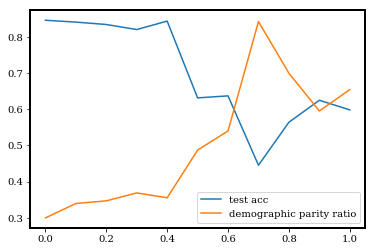

In [38]:
plt.clf()
plt.plot(x, test_acc, label='test acc')
plt.plot(x, dp, label='demographic parity ratio')
plt.legend()
plt.savefig("feldman_repair.png")

In [39]:
# repair level 0.9 seems to have ok demographic parity ratio and with a small drop in test accuracy
repairer = AIF.DisparateImpactRemover(repair_level=0.9, sensitive_attribute='race-sex')
repaired_train = repairer.fit_transform(ad_train)
repaired_test = repairer.fit_transform(ad_test)
repaired_df_train, repaired_attrs_train = repaired_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
repaired_df_test, repaired_attrs_test = repaired_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
Y_rep_train = np.array(repaired_df_train[['income-per-year']]).reshape(((len(repaired_df_train),)))
Xs_rep_train = np.array(repaired_df_train.drop(columns='income-per-year'))

Y_rep_test = np.array(repaired_df_test[['income-per-year']]).reshape(((len(repaired_df_test),)))
Xs_rep_test = np.array(repaired_df_test.drop(columns='income-per-year'))
clf_rep = LogisticRegression(max_iter = 300, solver='liblinear').fit(Xs_rep_train, Y_rep_train)
predicted_labels_rep = clf_rep.predict(Xs_rep_test).reshape((len(Y_rep_test), 1))
ad_pred_rep = deepcopy(ad_test)
ad_pred_rep.labels = predicted_labels_rep
metrics_rep = ClassificationMetric(ad_test,ad_pred_rep,unprivileged_groups=u, privileged_groups=p)
test_acc_rep = metrics_rep.accuracy()
DI_rep = metrics_rep.disparate_impact()
EO_rep = metrics_rep.average_abs_odds_difference()
print('Repair Test Accuracy:', test_acc_rep)
print('Repair Demographic Parity ratio:', DI_rep)
print('Repair Average Absolute Odds diff:', EO_rep)

Repair Test Accuracy: 0.6248580020046776
Repair Demographic Parity ratio: 0.5953345912631965
Repair Average Absolute Odds diff: 0.13032918174151628


### Membership Inference Attack

In [40]:
# Membership inference attack

repaired_shadow_train = repairer.fit_transform(shadow_train)
repaired_shadow_test = repairer.fit_transform(shadow_test)

shadow_train_df, _ = repaired_shadow_train.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
shadow_test_df, _ = repaired_shadow_test.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=True)
shadow_Xs_train = np.array(shadow_train_df.drop(columns='income-per-year'))
shadow_Xs_test = np.array(shadow_test_df.drop(columns='income-per-year'))


# train shadow model
true_pred_on_shadow_train = clf_rep.predict(shadow_Xs_train)
true_pred_on_shadow_test = clf_rep.predict(shadow_Xs_test)

shadow_model = LogisticRegression(max_iter = 300, solver='liblinear').fit(shadow_Xs_train, true_pred_on_shadow_train)

In [41]:
true_pred_on_shadow_train = true_pred_on_shadow_train.astype(int).reshape(len(true_pred_on_shadow_train),)
true_pred_on_shadow_test = true_pred_on_shadow_test.astype(int).reshape(len(true_pred_on_shadow_test),)

In [42]:
shadow_out_train = clf_rep.predict_proba(shadow_Xs_train)
shadow_out_test = clf_rep.predict_proba(shadow_Xs_test)
true_model_train = clf_rep.predict_proba(Xs_rep_train)
true_model_test = clf_rep.predict_proba(Xs_rep_test)

In [43]:
shadow_train_performance = (shadow_out_train, true_pred_on_shadow_train)
shadow_test_performance = (shadow_out_test, true_pred_on_shadow_test)
target_train_performance = (true_model_train, Y_train)
target_test_performance = (true_model_test, Y_test)

In [44]:
# run MIA
MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [45]:
MIA._mem_inf_benchmarks(shadow_attr_train, shadow_attr_test, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.608, with train acc 0.842 and test acc 0.625
For membership inference attack via confidence, group attr 0, the attack acc is 0.675
For membership inference attack via confidence, group attr 1, the attack acc is 0.599
For membership inference attack via confidence, group attr 2, the attack acc is 0.689
For membership inference attack via confidence, group attr 3, the attack acc is 0.571
For membership inference attack via confidence, group attr 4, the attack acc is 0.704
For membership inference attack via confidence, group attr 5, the attack acc is 0.545
For membership inference attack via confidence, group attr 6, the attack acc is 0.671
For membership inference attack via confidence, group attr 7, the attack acc is 0.601
For membership inference attack via confidence, the attack acc is 0.622
For membership inference attack via entropy, group attr 0, the attack acc is 0.675
For membership inference attack via entropy

In [46]:
# white box MIA for reference
MIA_wb = black_box_benchmarks(target_train_performance,target_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [47]:
MIA_wb._mem_inf_benchmarks(train_attr, test_attr, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.608, with train acc 0.842 and test acc 0.625
For membership inference attack via confidence, group attr 0, the attack acc is 0.766
For membership inference attack via confidence, group attr 1, the attack acc is 0.721
For membership inference attack via confidence, group attr 2, the attack acc is 0.788
For membership inference attack via confidence, group attr 3, the attack acc is 0.671
For membership inference attack via confidence, group attr 4, the attack acc is 0.813
For membership inference attack via confidence, group attr 5, the attack acc is 0.687
For membership inference attack via confidence, group attr 6, the attack acc is 0.757
For membership inference attack via confidence, group attr 7, the attack acc is 0.658
For membership inference attack via confidence, the attack acc is 0.695
For membership inference attack via entropy, group attr 0, the attack acc is 0.762
For membership inference attack via entropy

In [48]:
# measure memorization
gen_gap_per_group(true_model_train, Y_train, train_attr, true_model_test, Y_test, test_attr)

generalization gap for group 0: 0.16373108803182573
generalization gap for group 1: 0.5993458626994765
generalization gap for group 2: 0.33632992843068943
generalization gap for group 3: 0.3639825060234316
generalization gap for group 4: 0.3589775877981376
generalization gap for group 5: 0.4518100684968798
generalization gap for group 6: 0.4233788170934199
generalization gap for group 7: 0.46970920038987607


### Privacy Risk Score Analysis

In [49]:
tr_values = MIA._entr_comp(shadow_out_train)
te_values = MIA._entr_comp(shadow_out_test)
data_values = MIA._entr_comp(true_model_train)

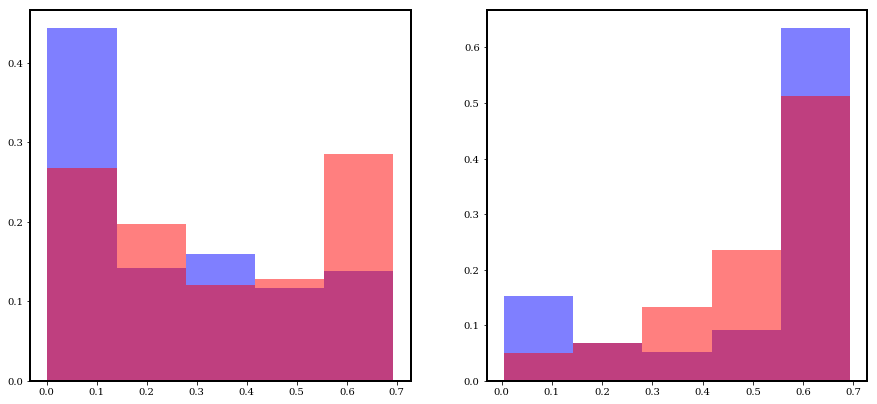

In [50]:
# get risk scores
risk_scores = calculate_risk_score(tr_values, te_values, 
                                   true_pred_on_shadow_train, 
                                   true_pred_on_shadow_test, 
                                   data_values, Y_train, num_bins=5, log_bins=False)

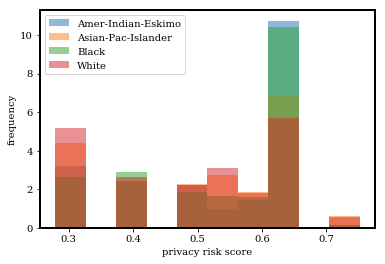

In [51]:
risk_hist(map_race, 'race', ad_df_train, risk_scores)

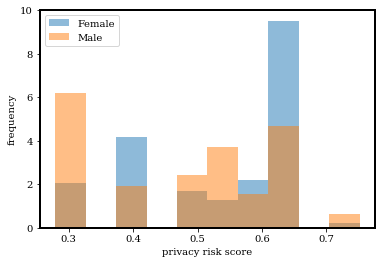

In [52]:
risk_hist(map_sex, 'sex', ad_df_train, risk_scores)

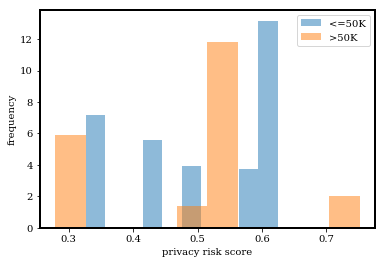

In [53]:
risk_hist(map_income, 'income-per-year', ad_df_train, risk_scores)

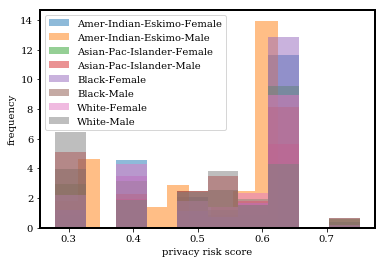

In [54]:
risk_hist(map_race_sex, 'race-sex', ad_df_train, risk_scores)

## Agarwal et al (Reduction)

In [55]:
from aif360.algorithms.inprocessing.exponentiated_gradient_reduction import ExponentiatedGradientReduction

In [56]:
estimator = LogisticRegression(solver='liblinear')
np.random.seed(0) #need for reproducibility
exp_grad_red_dp = ExponentiatedGradientReduction(estimator=estimator, 
                                              constraints="DemographicParity",
                                              drop_prot_attr=False)

In [57]:
exp_grad_red_dp.fit(ad_train)
exp_grad_red_pred_dp = exp_grad_red_dp.predict(ad_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [58]:
metrics_red_dp = ClassificationMetric(ad_test,exp_grad_red_pred_dp,unprivileged_groups=u, privileged_groups=p)
test_acc_red_dp = metrics_red_dp.accuracy()
DI_red_dp = metrics_red_dp.disparate_impact()
EO_red_dp = metrics_red_dp.average_abs_odds_difference()
print('DP Reduction Test Accuracy:', test_acc_red_dp)
print('DP Reduction Demographic Parity ratio:', DI_red_dp)
print('DP Reduction Average Absolute Odds diff:', EO_red_dp)

DP Reduction Test Accuracy: 0.8026729034413632
DP Reduction Demographic Parity ratio: 0.8863646735827712
DP Reduction Average Absolute Odds diff: 0.13793206099376182


### Membership Inference Attack

In [59]:
# Membership inference attack

# train shadow model
true_pred_on_shadow_train = exp_grad_red_dp.predict(shadow_train)
true_pred_on_shadow_test = exp_grad_red_dp.predict(shadow_test)

shadow_model = LogisticRegression(max_iter = 300, solver='liblinear').fit(shadow_Xs_train, true_pred_on_shadow_train.labels)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [60]:
true_pred_on_shadow_train = true_pred_on_shadow_train.labels.astype(int).reshape(len(true_pred_on_shadow_train.labels),)
true_pred_on_shadow_test = true_pred_on_shadow_test.labels.astype(int).reshape(len(true_pred_on_shadow_test.labels),)

In [61]:
shadow_out_train = exp_grad_red_dp.model.predict_proba(shadow_Xs_train)
shadow_out_test = exp_grad_red_dp.model.predict_proba(shadow_Xs_test)
true_model_train = exp_grad_red_dp.model.predict_proba(Xs_train)
true_model_test = exp_grad_red_dp.model.predict_proba(Xs_test)

In [62]:
shadow_train_performance = (shadow_out_train, true_pred_on_shadow_train)
shadow_test_performance = (shadow_out_test, true_pred_on_shadow_test)
target_train_performance = (true_model_train, Y_train)
target_test_performance = (true_model_test, Y_test)

In [63]:
# run MIA
MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [64]:
MIA._mem_inf_benchmarks(shadow_attr_train, shadow_attr_test, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.500, with train acc 0.817 and test acc 0.817
For membership inference attack via confidence, group attr 0, the attack acc is 0.527
For membership inference attack via confidence, group attr 1, the attack acc is 0.495
For membership inference attack via confidence, group attr 2, the attack acc is 0.493
For membership inference attack via confidence, group attr 3, the attack acc is 0.520
For membership inference attack via confidence, group attr 4, the attack acc is 0.493
For membership inference attack via confidence, group attr 5, the attack acc is 0.496
For membership inference attack via confidence, group attr 6, the attack acc is 0.499
For membership inference attack via confidence, group attr 7, the attack acc is 0.500
For membership inference attack via confidence, the attack acc is 0.499
For membership inference attack via entropy, group attr 0, the attack acc is 0.513
For membership inference attack via entropy

In [65]:
# white box MIA for reference
MIA_wb = black_box_benchmarks(target_train_performance,target_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [66]:
MIA_wb._mem_inf_benchmarks(train_attr, test_attr, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.500, with train acc 0.817 and test acc 0.817
For membership inference attack via confidence, group attr 0, the attack acc is 0.556
For membership inference attack via confidence, group attr 1, the attack acc is 0.512
For membership inference attack via confidence, group attr 2, the attack acc is 0.502
For membership inference attack via confidence, group attr 3, the attack acc is 0.577
For membership inference attack via confidence, group attr 4, the attack acc is 0.510
For membership inference attack via confidence, group attr 5, the attack acc is 0.506
For membership inference attack via confidence, group attr 6, the attack acc is 0.502
For membership inference attack via confidence, group attr 7, the attack acc is 0.502
For membership inference attack via confidence, the attack acc is 0.504
For membership inference attack via entropy, group attr 0, the attack acc is 0.539
For membership inference attack via entropy

In [67]:
# measure memorization
gen_gap_per_group(true_model_train, Y_train, train_attr, true_model_test, Y_test, test_attr)

generalization gap for group 0: 0.22956311276442898
generalization gap for group 1: 0.1210844362019598
generalization gap for group 2: 0.08764173265421871
generalization gap for group 3: 0.23540117317028186
generalization gap for group 4: 0.20295860227670415
generalization gap for group 5: 0.04160749616046394
generalization gap for group 6: 0.0022154603072443435
generalization gap for group 7: 0.016974325154452075


### Privacy Risk Score Analysis

In [68]:
tr_values = MIA._entr_comp(shadow_out_train)
te_values = MIA._entr_comp(shadow_out_test)
data_values = MIA._entr_comp(true_model_train)

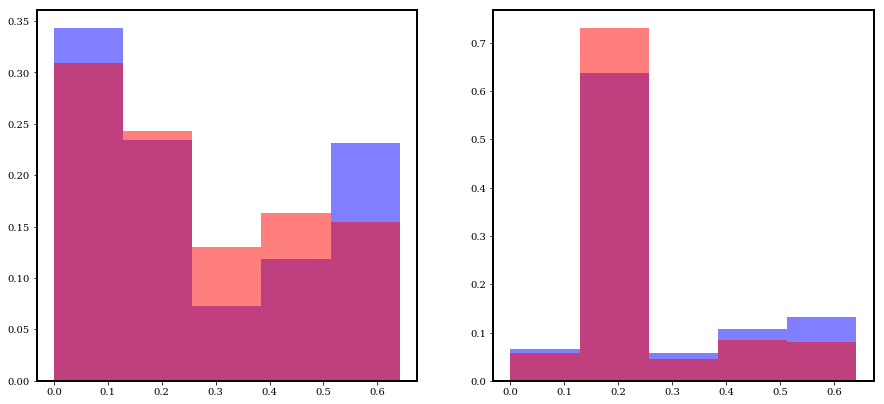

In [69]:
# get risk scores
risk_scores = calculate_risk_score(tr_values, te_values, 
                                   true_pred_on_shadow_train, 
                                   true_pred_on_shadow_test, 
                                   data_values, Y_train, num_bins=5, log_bins=False)

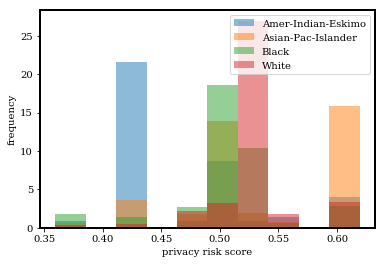

In [70]:
risk_hist(map_race, 'race', ad_df_train, risk_scores)

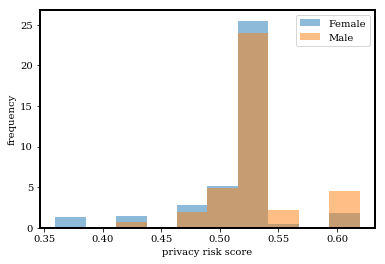

In [71]:
risk_hist(map_sex, 'sex', ad_df_train, risk_scores)

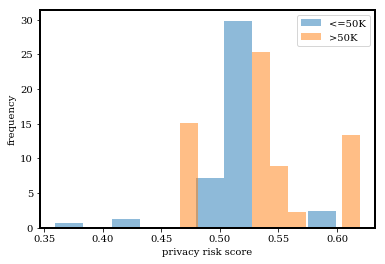

In [72]:
risk_hist(map_income, 'income-per-year', ad_df_train, risk_scores)

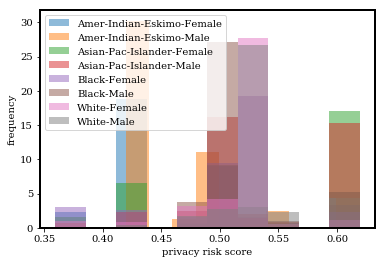

In [73]:
risk_hist(map_race_sex, 'race-sex', ad_df_train, risk_scores)

# Equalized Odds (Separation)

## Hardt et al. (Postprocessing)

In [74]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing

In [75]:
postprocessing = EqOddsPostprocessing(u, p)

In [76]:
postprocessing = postprocessing.fit(ad_train, ad_pred_train)
postprocess_pred = postprocessing.predict(ad_pred)

In [77]:
metrics_post = ClassificationMetric(ad_test,postprocess_pred,unprivileged_groups=u, privileged_groups=p)
test_acc_post = metrics_post.accuracy()
DI_post = metrics_post.disparate_impact()
EO_ppost = metrics_post.average_abs_odds_difference()
print('Postprocessing Test Accuracy:', test_acc_post)
print('Postprocessing Demographic Parity ratio:', DI_post)
print('Postprocessing Average Absolute Odds diff:', EO_ppost)

Postprocessing Test Accuracy: 0.8140995656531907
Postprocessing Demographic Parity ratio: 0.6174765669542002
Postprocessing Average Absolute Odds diff: 0.007857657450268743


### Membership Inference Attack

In [78]:
# Membership inference attack

# train shadow model
true_pred_on_shadow_train = postprocessing.predict(shadow_train)
true_pred_on_shadow_test = postprocessing.predict(shadow_test)

shadow_model = LogisticRegression(max_iter = 300, solver='liblinear').fit(shadow_Xs_train, true_pred_on_shadow_train.labels)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [79]:
true_pred_on_shadow_train = true_pred_on_shadow_train.labels.astype(int).reshape(len(true_pred_on_shadow_train.labels),)
true_pred_on_shadow_test = true_pred_on_shadow_test.labels.astype(int).reshape(len(true_pred_on_shadow_test.labels),)

In [80]:
# TODO: probabilities from hardt postprocessing technique
shadow_out_train = clf.predict_proba(shadow_Xs_train)
shadow_out_test = clf.predict_proba(shadow_Xs_test)
true_model_train = clf.predict_proba(Xs_train)
true_model_test = clf.predict_proba(Xs_test)

In [81]:
shadow_train_performance = (shadow_out_train, true_pred_on_shadow_train)
shadow_test_performance = (shadow_out_test, true_pred_on_shadow_test)
target_train_performance = (true_model_train, Y_train)
target_test_performance = (true_model_test, Y_test)

In [82]:
# run MIA
MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [83]:
MIA._mem_inf_benchmarks(shadow_attr_train, shadow_attr_test, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.499, with train acc 0.845 and test acc 0.846
For membership inference attack via confidence, group attr 0, the attack acc is 0.481
For membership inference attack via confidence, group attr 1, the attack acc is 0.519
For membership inference attack via confidence, group attr 2, the attack acc is 0.516
For membership inference attack via confidence, group attr 3, the attack acc is 0.491
For membership inference attack via confidence, group attr 4, the attack acc is 0.512
For membership inference attack via confidence, group attr 5, the attack acc is 0.504
For membership inference attack via confidence, group attr 6, the attack acc is 0.499
For membership inference attack via confidence, group attr 7, the attack acc is 0.500
For membership inference attack via confidence, the attack acc is 0.501
For membership inference attack via entropy, group attr 0, the attack acc is 0.505
For membership inference attack via entropy

In [84]:
# white box MIA for reference
MIA_wb = black_box_benchmarks(target_train_performance,target_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [85]:
MIA_wb._mem_inf_benchmarks(train_attr, test_attr, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.499, with train acc 0.845 and test acc 0.846
For membership inference attack via confidence, group attr 0, the attack acc is 0.551
For membership inference attack via confidence, group attr 1, the attack acc is 0.581
For membership inference attack via confidence, group attr 2, the attack acc is 0.571
For membership inference attack via confidence, group attr 3, the attack acc is 0.534
For membership inference attack via confidence, group attr 4, the attack acc is 0.524
For membership inference attack via confidence, group attr 5, the attack acc is 0.518
For membership inference attack via confidence, group attr 6, the attack acc is 0.509
For membership inference attack via confidence, group attr 7, the attack acc is 0.504
For membership inference attack via confidence, the attack acc is 0.509
For membership inference attack via entropy, group attr 0, the attack acc is 0.560
For membership inference attack via entropy

In [86]:
# measure memorization
gen_gap_per_group(true_model_train, Y_train, train_attr, true_model_test, Y_test, test_attr)

generalization gap for group 0: 0.026538831210573266
generalization gap for group 1: 0.09866577643288499
generalization gap for group 2: 0.17538865348881075
generalization gap for group 3: 0.002220065245218228
generalization gap for group 4: 0.01795451880166976
generalization gap for group 5: 0.00017744523551793678
generalization gap for group 6: 0.000796687713221389
generalization gap for group 7: 0.011224237990104968


### Privacy Risk Score Analysis

In [87]:
tr_values = MIA._entr_comp(shadow_out_train)
te_values = MIA._entr_comp(shadow_out_test)
data_values = MIA._entr_comp(true_model_train)

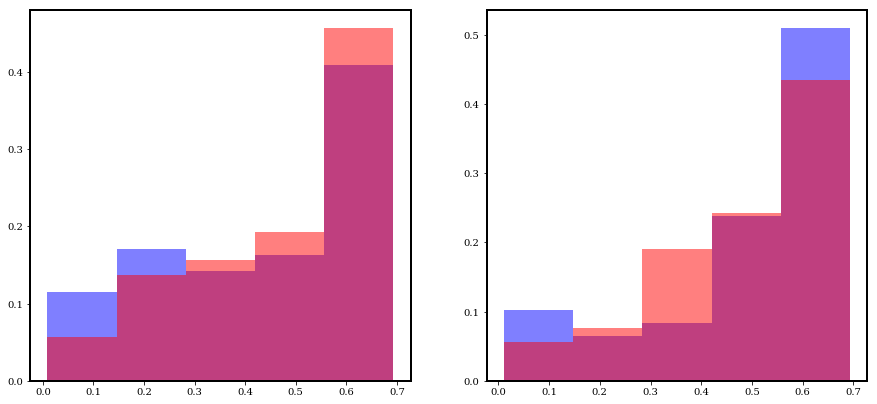

In [88]:
# get risk scores
risk_scores = calculate_risk_score(tr_values, te_values, 
                                   true_pred_on_shadow_train, 
                                   true_pred_on_shadow_test, 
                                   data_values, Y_train, num_bins=5, log_bins=False)

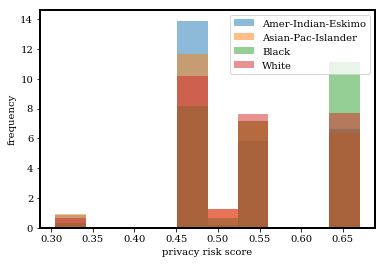

In [89]:
risk_hist(map_race, 'race', ad_df_train, risk_scores)

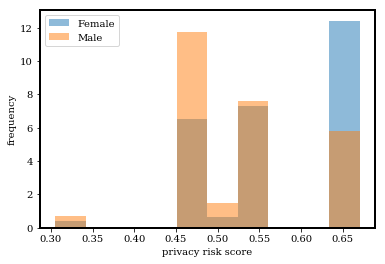

In [90]:
risk_hist(map_sex, 'sex', ad_df_train, risk_scores)

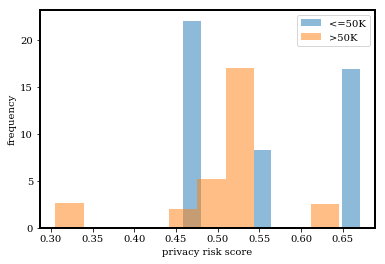

In [91]:
risk_hist(map_income, 'income-per-year', ad_df_train, risk_scores)

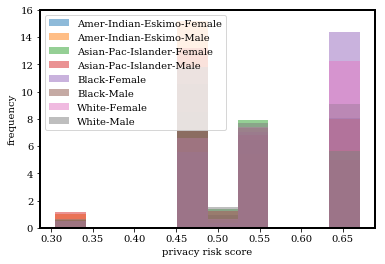

In [92]:
risk_hist(map_race_sex, 'race-sex', ad_df_train, risk_scores)

## Agarwal et al (Reduction)

In [93]:
estimator = LogisticRegression(solver='liblinear')
np.random.seed(0) #need for reproducibility
exp_grad_red = ExponentiatedGradientReduction(estimator=estimator, 
                                              constraints="EqualizedOdds",
                                              drop_prot_attr=False)

In [94]:
exp_grad_red.fit(ad_train)
exp_grad_red_pred = exp_grad_red.predict(ad_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [95]:
metrics_red_eo = ClassificationMetric(ad_test,exp_grad_red_pred,unprivileged_groups=u, privileged_groups=p)
test_acc_red_eo = metrics_red_eo.accuracy()
DI_red_eo = metrics_red_eo.disparate_impact()
EO_red_eo = metrics_red_eo.average_abs_odds_difference()
print('EO Reduction Test Accuracy:', test_acc_red_eo)
print('EO Reduction Demographic Parity ratio:', DI_red_eo)
print('EO Reduction Average Absolute Odds diff:', EO_red_eo)

EO Reduction Test Accuracy: 0.7929836284664217
EO Reduction Demographic Parity ratio: 0.573711529289617
EO Reduction Average Absolute Odds diff: 0.022731095923982356


### Membership Inference Attack

In [96]:
# Membership inference attack

# train shadow model
true_pred_on_shadow_train = exp_grad_red.predict(shadow_train)
true_pred_on_shadow_test = exp_grad_red.predict(shadow_test)

shadow_model = LogisticRegression(max_iter = 300, solver='liblinear').fit(shadow_Xs_train, true_pred_on_shadow_train.labels)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [97]:
true_pred_on_shadow_train = true_pred_on_shadow_train.labels.astype(int).reshape(len(true_pred_on_shadow_train.labels),)
true_pred_on_shadow_test = true_pred_on_shadow_test.labels.astype(int).reshape(len(true_pred_on_shadow_test.labels),)

In [98]:
shadow_out_train = exp_grad_red.model.predict_proba(shadow_Xs_train)
shadow_out_test = exp_grad_red.model.predict_proba(shadow_Xs_test)
true_model_train = exp_grad_red.model.predict_proba(Xs_train)
true_model_test = exp_grad_red.model.predict_proba(Xs_test)

In [99]:
shadow_train_performance = (shadow_out_train, true_pred_on_shadow_train)
shadow_test_performance = (shadow_out_test, true_pred_on_shadow_test)
target_train_performance = (true_model_train, Y_train)
target_test_performance = (true_model_test, Y_test)

In [100]:
# run MIA
MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [101]:
MIA._mem_inf_benchmarks(shadow_attr_train, shadow_attr_test, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.501, with train acc 0.834 and test acc 0.832
For membership inference attack via confidence, group attr 0, the attack acc is 0.499
For membership inference attack via confidence, group attr 1, the attack acc is 0.530
For membership inference attack via confidence, group attr 2, the attack acc is 0.496
For membership inference attack via confidence, group attr 3, the attack acc is 0.562
For membership inference attack via confidence, group attr 4, the attack acc is 0.504
For membership inference attack via confidence, group attr 5, the attack acc is 0.504
For membership inference attack via confidence, group attr 6, the attack acc is 0.501
For membership inference attack via confidence, group attr 7, the attack acc is 0.500
For membership inference attack via confidence, the attack acc is 0.502
For membership inference attack via entropy, group attr 0, the attack acc is 0.528
For membership inference attack via entropy

In [102]:
# white box MIA for reference
MIA_wb = black_box_benchmarks(target_train_performance,target_test_performance,
                         target_train_performance,target_test_performance,num_classes=2)

In [103]:
MIA_wb._mem_inf_benchmarks(train_attr, test_attr, train_attr, test_attr)

For membership inference attack via correctness, the attack acc is 0.501, with train acc 0.834 and test acc 0.832
For membership inference attack via confidence, group attr 0, the attack acc is 0.579
For membership inference attack via confidence, group attr 1, the attack acc is 0.559
For membership inference attack via confidence, group attr 2, the attack acc is 0.539
For membership inference attack via confidence, group attr 3, the attack acc is 0.545
For membership inference attack via confidence, group attr 4, the attack acc is 0.510
For membership inference attack via confidence, group attr 5, the attack acc is 0.518
For membership inference attack via confidence, group attr 6, the attack acc is 0.506
For membership inference attack via confidence, group attr 7, the attack acc is 0.503
For membership inference attack via confidence, the attack acc is 0.507
For membership inference attack via entropy, group attr 0, the attack acc is 0.573
For membership inference attack via entropy

In [104]:
# measure memorization
gen_gap_per_group(true_model_train, Y_train, train_attr, true_model_test, Y_test, test_attr)

generalization gap for group 0: 0.05642607700398963
generalization gap for group 1: 0.8273891448726809
generalization gap for group 2: 0.15353303587886147
generalization gap for group 3: 0.3745908827219546
generalization gap for group 4: 0.10985327053252847
generalization gap for group 5: 0.1591995834940667
generalization gap for group 6: 0.07194630524279455
generalization gap for group 7: 0.09035579466786015


### Privacy Risk Score Analysis

In [105]:
tr_values = MIA._entr_comp(shadow_out_train)
te_values = MIA._entr_comp(shadow_out_test)
data_values = MIA._entr_comp(true_model_train)

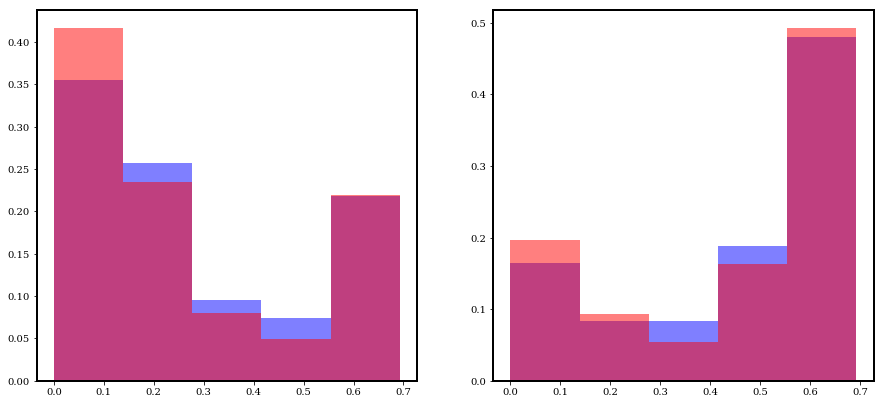

In [106]:
# get risk scores
risk_scores = calculate_risk_score(tr_values, te_values, 
                                   true_pred_on_shadow_train, 
                                   true_pred_on_shadow_test, 
                                   data_values, Y_train, num_bins=5, log_bins=False)

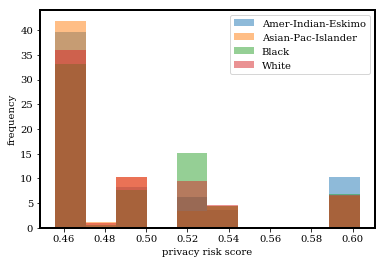

In [107]:
risk_hist(map_race, 'race', ad_df_train, risk_scores)

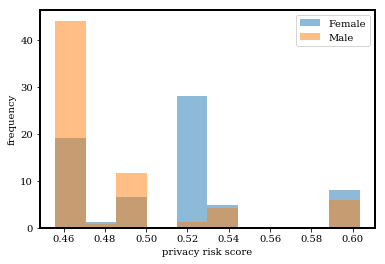

In [108]:
risk_hist(map_sex, 'sex', ad_df_train, risk_scores)

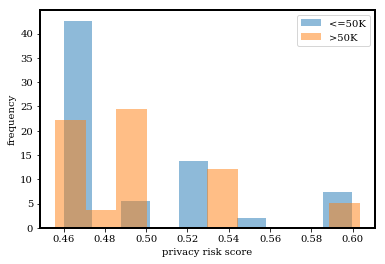

In [109]:
risk_hist(map_income, 'income-per-year', ad_df_train, risk_scores)

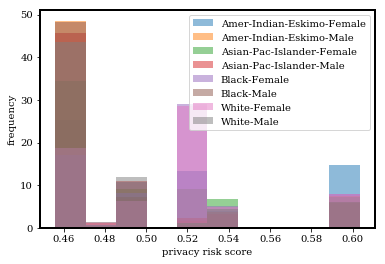

In [110]:
risk_hist(map_race_sex, 'race-sex', ad_df_train, risk_scores)